In [1]:
import numpy as np
import skfuzzy as fuzz
import skfuzzy.control as ctrl
from skfuzzy.control.term import Term,WeightedTerm,TermAggregate
from skfuzzy.control.rule import Rule
from skfuzzy.control.fuzzyvariable import FuzzyVariable
from skfuzzy.control.antecedent_consequent import Antecedent,Consequent
from skfuzzy.control.controlsystem import ControlSystemSimulation
from skfuzzy import interp_membership,interp_universe,defuzz
import math
from itertools import product as prd
from datatransformer import PersonalDataTransformer,AllDataTransformer
import pandas as pd
import datetime

In [2]:
class fuzzylogic_trimf_3stage_rule():
    def __init__(self,input_name,input_min,input_max,range_list_2D):
        self.input_name = input_name
        self.input_min = input_min
        self.input_max = input_max+1
        self.range_list = range_list_2D
        
    def set_input_range(self,interval):
        min = self.input_min
        max = self.input_max
        range = np.arange(min,max,interval,np.float32)
        return range
    
    def set_antecedent(self,antecedent_range):
        antecedent = ctrl.Antecedent(antecedent_range,self.input_name)
        for i in range(3):
            stage_name = 'stage'+str(i)
            antecedent[stage_name] = fuzz.membership.trimf(antecedent_range,self.range_list[i])
        return antecedent

    def set_consequent(self,consequent_range):
        consequent_ = ctrl.Consequent(consequent_range,self.input_name)
        for i in range(3):
            stage_name = 'stage'+str(i)
            consequent_[stage_name] = fuzz.membership.trimf(consequent_range,self.range_list[i])
        return consequent_

    def view_antecedent(self,antecedent):
        antecedent.view()


In [3]:
class fuzzylogic_system():
    def __init__(self,final_value_membership,antecedent_list,defuzzy_method='centroid'):
        self.final_membership = final_value_membership
        self.numberOFantecedent = len(antecedent_list)
        self.antecedent_list = antecedent_list
        self.defuzzy_method = defuzzy_method
    
    def set_antecedent_dicandlist(self,numberOFstage):
        final_antecedent_dictlist = []
        antecedent_dict ={}
        for i in range(self.numberOFantecedent):
            antecedent_dict ={}
            antecedent = self.antecedent_list[i]
            for j in range(numberOFstage):
                antecedent_dict['stage'+str(j)] = antecedent['stage'+str(j)]
            final_antecedent_dictlist.append(antecedent_dict)
        
        return final_antecedent_dictlist

    def set_antecedent_2Dlist(self,numberOFstage=3):
        final_antecedent_list = []
        for i in range(self.numberOFantecedent):
            antecedent = self.antecedent_list[i]
            for j in range(numberOFstage):
                final_antecedent_list.append(antecedent['stage'+str(j)])

        final_antecedent_2Dlist = np.array(final_antecedent_list).reshape(self.numberOFantecedent,numberOFstage)
        
        """
        final_antecedent_list
        
                       stage 
                     ----------
                    | A0 A1 A2 |              
        antecedent  | B0 B1 B2 |
                    |    ...   |
                     ----------
        """

        return final_antecedent_2Dlist

    def set_rule(self,final_antecedent_2Dlist):

        
        # one hot encoder
        size = 0
        for i in range(final_antecedent_2Dlist.shape[0]):
            size = size + 2*pow(3,i)

        onehot = np.zeros(size+1)
        
        onehot_value = {}
        for i in range(final_antecedent_2Dlist.shape[0]):
            for j in range(final_antecedent_2Dlist.shape[1]):
                key = final_antecedent_2Dlist[i][j]
                value = pow(3,i)*j
                onehot_value[key] = value

        
        
        #rule high
        n = 0
        for i in range(self.numberOFantecedent):
            rule = final_antecedent_2Dlist[i][2]
            n = n+onehot_value.get(rule)
            if i==0:
                rule_high = final_antecedent_2Dlist[i][2]
            else:
                rule_high = rule_high & final_antecedent_2Dlist[i][2]
            # rule_onehot[size-1] = 1 #one-hot 位置 =1
            onehot[n] = 1

        #rule medium
        medium_1 = np.array(list(prd(*final_antecedent_2Dlist[:,1:3])))
        medium_pass = []
        for i in range(medium_1.shape[0]-1):
            n = 0
            for j in range(medium_1.shape[1]):
                rule = medium_1[i][j]
                n = onehot_value.get(rule) + n 
                if j==0 :
                    base = medium_1[i][j]
                else:
                    add = medium_1[i][j]
                    base = base&add
            if onehot[n] == 0:
                onehot[n] = 1    
                medium_pass.append(base) # 1D and :[and rule1,and rule2,.....] 

        for i in range(len(medium_pass)):
            if i == 0:
                rule_medium = medium_pass[i]
            else:
                rule_medium = rule_medium | medium_pass[i]

        #rule low
        low_1 = np.array(list(prd(*final_antecedent_2Dlist)))

        low_pass = []
        for i in range(low_1.shape[0]):
            n=0
            for j in range(low_1.shape[1]):
                rule = low_1[i][j]
                n = onehot_value.get(rule) + n 
                if j==0 :
                    base = low_1[i][j]
                else:
                    add = low_1[i][j]
                    base = base&add
            if onehot[n] == 0:
                onehot[n] = 1    
                low_pass.append(base) # 1D and :[and rule1,and rule2,.....] 
        
        for i in range(len(low_pass)):
            if i == 0:
                rule_low = low_pass[i]
            else:
                rule_low = rule_low | low_pass[i]

        return rule_low,rule_medium,rule_high

    def defuzzy_function(self,rule_low,rule_medium,rule_high,valuedictionary,consequent_string):
        y  = self.final_membership
        y.defuzzify_method = self.defuzzy_method
        print('defuzzy method:',self.defuzzy_method)
        print('--------------------------------')
        low_rule = ctrl.Rule(antecedent=rule_low,consequent=self.final_membership['stage0'],label='stage0')
        medium_rule = ctrl.Rule(antecedent=rule_medium,consequent=self.final_membership['stage1'],label='stage1')
        high_rule = ctrl.Rule(antecedent=rule_high,consequent=self.final_membership['stage2'],label='stage2')
        print('finish rule setting')
        print('--------------------------------')
        
        system = ctrl.ControlSystem(rules = [low_rule,medium_rule,high_rule])
        SA = ctrl.ControlSystemSimulation(system)
        print('finish system initialization')
        print('--------------------------------')

        for i in valuedictionary:
            print(i,":",valuedictionary.get(i))
            SA.input[i] = valuedictionary.get(i)
        
        print('finish value setting')
        print('--------------------------------')
        
        
        SA.compute()
        print('finish computing')
        print('--------------------------------')
        output_value = SA.output
        #print(output_value.get(consequent_string))
        print('FINAL GRADE: ',format(output_value.get(consequent_string),'.2f'))
        
        return SA
    
    def view_output(self,initial_system,antecedent_list):
        for i in antecedent_list:
            i.view(sim=initial_system)

    
    def print_rules(self,system):
        # system is initialized
        rule_number = {}
        for rn, r in enumerate(system.ctrl.rules):
            rule_number[r] = "RULE #%d" % rn
            print("RULE #%d:\n  %s\n" % (rn, r))

    def record_input_value(self,system):
        value = {}
        for i in system.ctrl.antecedents:
            key = str(i)
            print(str(i))
            value[key]=i.input[system]
        
        return value
    

In [4]:

#特休計算
def count_pto(start_year:int,start_month:int,start_day:int):
    now = datetime.date.today()
    start = datetime.date(start_year,start_month,start_day)

    day = now - start

    d1 =  datetime.timedelta(days=183)
    d2 =  datetime.timedelta(days=365)
    d3 =  datetime.timedelta(days=730)
    d4 =  datetime.timedelta(days=1095)
    d5 =  datetime.timedelta(days=1460)
    d6 =  datetime.timedelta(days=3650)


    #到職未滿半年0天特休。
    if day < d1 : 
        pto = 0
    #到職滿半年未滿一年者，給予三天特休。
    elif d1<=day<d2:
        pto = 3
    #到職滿一年未滿二年者，給予七天特休。
    elif d2<=day<d3:
        pto = 7
    #到職滿二年未滿三年者，給予十天特休。
    elif d3<=day<d4:
        pto = 10
    #到職滿三年未滿五年者，給予十四天特休。
    elif d4<=day<d5:
        pto = 14
    #到職滿五年未滿十年者，給予十五天特休。
    elif d5<=day<d6:
        pto = 15
    #到職十年以上者，每一年加給一日，加至三十天為止。
    elif day>=d6:
        subday = day-d6
        pto = (subday//d2)+16

    return pto




class personalINFO():
    def __init__(self,name:str,title,PersonalShift:pd.DataFrame,start_year:int,start_month:int,start_day:int):
        self.__title = title
        """
        護理長:S        副護理長:A      組長:B      代理組長:C
        護理師、護士(年資3年以上):D     護理師、護士(年資1~3年):E
        護理師、護士(年資1年以下):F     護理師、護士(年資未滿3個月):G
        控台護理師:H    前台護理師:I    兼職人員(護理師):J
        門診手術室護理師:K              助理:L
        書記:M                          支援人力(技術師):T
        """
        self.__yearoff =count_pto(start_year,start_month,start_day)  #特休天數計算
        self.name = name
        self.personalshift = PersonalShift
        self.nationalholiday = []
        self.overtime = 0 #若七天裡至少要休一天，若只休一天，第六天為加班(納入積假) -> overall checking之後過更新
        self.trip = []
        self.personal_leave =14 #事假每年上限 只需要更新事假

    def return_title(self):
         return self.__title
    def return_yearoff(self):
         return self.__yearoff
    def return_name(self):
        return self.name

    def return_personalshift(self):
        return self.personalshift
    
    def return_shift(self):

        title = self.title
        if title == 'S':
            personal_shift = [4080,8015,200,280,4160,380,301] #301 = 300P
        elif title == 'A':
            personal_shift = [4070,4080,8015,200,280,4240,380,300]
        elif title == 'B':
            personal_shift = [4070,4075,4080,8015,4090,200,280,4160,380,300]
        elif title == 'C':
            personal_shift = [4070,4075,4080,8015,4090,200,280,4160,380,300]
        elif title == 'D':
            personal_shift = [4070,4075,4080,8015,4090,200,280,4126,4140,4160,4240,380,300]
        elif title == 'E':
            personal_shift = [4075,4080,8015,4090,200,280,4126,4160,4240,380,300]
        elif title == 'F':
            personal_shift =[4075,4080,8015,4090,200,280,4126,4060,380,300]
        elif title == 'G':
            personal_shift = [4080,8015,200,280,4126]
        elif title == 'H':
            personal_shift = [4070,271]
        elif title == 'I':
            personal_shift = [4080,8015,4090,200,280,380,300]
        elif title == 'J':
            personal_shift = [4080,280]
        elif title == 'k':
            personal_shift = [4080,4085,200,280,380,300]
        elif title == 'L':
            personal_shift = [4070,4080,8015,200,280,4126,4140,380,300,8054]
        elif title == 'M':
            personal_shift = [8015,200,280,380,300]
        elif title == 'T':
            personal_shift = [4080,200,280,380,300]

        return personal_shift
    
    def return_overtime(self):
        return self.overtime
    
    def return_trip(self):
        return self.trip
    
    def update_yearoff(self,new_yearoff):
        self.__yearoff =new_yearoff
        print(f'success updating yearoff,new yearoff is {self.__yearoff} ')

    def update_nationalholiday(self,new_nationalholiday:list):
        tmp = self.nationalholiday
        for i in new_nationalholiday:
            tmp.append(i)
        print(f'success updating national holiday, new holiday is {self.nationalholiday}')

    """積假:還沒好"""
    def update_overtime(self,NewOverTime):
        #從overall checking 過來改
        self.overtime = NewOverTime
        print("success updating over-time")

    def update_trip(self,New_trip):
        for i in New_trip:
            self.trip.append(i)
        print(f'success updating trip,new trip is {self.trip}')
        
    def CountOffDay(self,offday_shift:pd.DataFrame):

        s = offday_shift
        holiday = 0 #國定假日+旅遊
        yearoff = 0 #特休 105->0.5天 yearoff ->1天
        fourdayoff = 0 #預排休四天 = 例假日+OFF
        leave={'家庭照顧假':0,'上課':0,'病假':0,'事假':0,'婚假':0,'公假':0,'生理假':0,'育嬰假':0,'產假':0,'喪假':0}
        for i in s.iloc[2]:
            if pd.isna(i) == False:
                #請假
                if i in leave:
                    leave[i]+=1
                #預排休四天
                elif i.upper() == 'OFF':
                    fourdayoff += 1
                elif i == '0.5OFF':
                    fourdayoff += 0.5
                #特休
                elif i == 'yearoff':
                    yearoff += 1
                elif i == '0.5yearoff':
                    yearoff += 0.5
                #半天特休半天例假日
                elif i == '105':
                    yearoff += 0.5
                    fourdayoff += 0.5
                #國定假日
                elif i == 'holiday':
                    holiday += 1

        print(f'預排休天數:{fourdayoff} \n預計國定假日+旅遊假天數:{holiday}\n預計特休天數:{yearoff}')
        print('請假天數')
        for i in leave:
            print(f'{i}:{leave.get(i)}')

        return holiday,leave,yearoff,fourdayoff

    def CountOnday(self,allshift): #要從做六休一的班表傳過來 -> 從 overall
        personal = allshift.loc[self.name]
        onday = 0
        for i  in personal:
            if i == 'on':
                onday += 1
        print(f'本月上班天數:{onday}')
        return onday
    




In [5]:
class schedule_checking():
    def __init__(self,min_dayoff=4):
        self.state = 0
        self.min_dayoff = min_dayoff # 每月預排休 最少天數
        
        #yearoff
        self.updateYEAROFF = False
        self.yearoff = -1 #剩餘天數
        self.inputyearoff = -1 #輸入天數

        #national holiday
        self.national_accep = []
        self.national_unaccep = []

        #trip
        self.updateTrip = False
        self.trip_accep = []
        self.trip_unaccep = []

        #print suggestion
        self.suggestiondayoff = 0
        self.suggestionyearoff = 0
        self.suggestionsaturdayoff = 0
        self.suggestionnationalholiday = 0
        self.suggestiontrip = 0

    def suggestionOFdayoff(self,value_antecedent1):
        #antecedent1 suggestion: 每人每月可預排4天
        if value_antecedent1 < self.min_dayoff :
            #print(f"每月預排休不足{self.min_dayoff}天\n")
            self.suggestiondayoff = 1
            grade = 5
            return grade
        if value_antecedent1 > self.min_dayoff : 
            #print(f"每月預排休超過{self.min_dayoff}天\n")
            self.suggestiondayoff = 2
            grade = 2
            return grade
        if value_antecedent1 == self.min_dayoff:
            #print(f"每月預排休4天 符合規定\n")
            self.suggestiondayoff= 3
            grade = 10
            return grade

    def suggestionOFyearoff(self,yearoff,value_antecedent2):
        #antecedent2 suggestion:
        #剩餘年度公休 yearoff
        
        if yearoff < value_antecedent2 :
            #print(f"剩餘年度公休為{yearoff}天，本月不予以公休{value_antecedent2}天，請重新排公休\n")
            self.updateYEAROFF = False
            self.yearoff = yearoff
            self.inputyearoff = value_antecedent2
            self.suggestionyearoff = 1
            grade = 2
            return self.updateYEAROFF,yearoff,grade

        if yearoff == value_antecedent2 :
            yearoff = 0
            #print(f"年度公休本月已排休完畢，接下來無年度公休可安排\n")
            self.updateYEAROFF = True
            self.yearoff = yearoff
            self.inputyearoff = value_antecedent2
            self.suggestionyearoff = 2
            grade = 10
            return self.updateYEAROFF,yearoff,grade
        
        if yearoff > value_antecedent2 :
            yearoff = yearoff - value_antecedent2
            #print(f"本月預排公休天數為{value_antecedent2}，剩餘可休天數為{yearoff}天\n")
            self.updateYEAROFF = True
            self.yearoff = yearoff
            self.inputyearoff = value_antecedent2
            self.suggestionyearoff = 3
            grade = 10
            return self.updateYEAROFF,yearoff,grade

    # def suggestionOFsaturdayoff(self,value_antecedent3):
    #     #******這個要在想一下要不要放在personal的class*****#
    #     #antecedent3 suggestion: 星期六可排休 星期日需上班一天
    #     #星期六無排休 input 6 -> X
    #     #星期六有排休且星期日有上班 input 8 -> suggestion
    #     #星期六有排休但星期日無上班 input 1 -> suggestion
    #     if value_antecedent3 == 8:
    #         #print('本月星期六有排休且星期日有上班')
    #         return 1
    #     if value_antecedent3 == 1:
    #         #print('本月星期六有排休但星期日無排班')
    #         return 2 

    def suggestionOFnationalholiday(self,personalshift:pd.DataFrame,PastNationalHoliday:list):
        """
        personalshift 個人班表
        PastNationalHoliday 從personalIFO取得 之前休過的假期
        """
        holiday = ['元旦','228','國慶','清明','端午','中秋','春節','兒童','勞動']
        tobecheck = personalshift.iloc[2]
        
        CheckShift= []

        newyear = int(personalshift.index.to_list()[0])-1911
        newholiday = []

        OriginalYear = []
        OriginalHoliday = []

        unaceep = []

        for i in tobecheck:
            if i in holiday:
                if i not in CheckShift:
                    CheckShift.append(i)

        for n in PastNationalHoliday:
            year = int(n[0:3])
            holi = n[3:]
            OriginalYear.append(year)
            OriginalHoliday.append(holi)

        for l in CheckShift:                    
            # print(f'--------------')
            # print(f'CheckShift = {l}')
            # print(f'--------------')
            intimes = 0
            min = 100
            for m in range(len(OriginalHoliday)):
                #print(f'OriginalHoliday= {OriginalHoliday[m]}')
                if l == OriginalHoliday[m]:
                    intimes += 1
                    #print(f'intimes= {intimes}')
                    diff = newyear - OriginalYear[m]
                    if min > diff:
                        min = diff
                        #print(f'min= {min}')
                else:
                    pass
                    #print(f'not match')
            if min >= 2 or intimes == 0:
                #print(f'append new holiday: {str(newyear)+l}')
                newholiday.append(str(newyear)+l)
            else:
                unaceep.append(str(newyear)+l)
        #return grade
        if len(newholiday) == 0:
            grade = 9
        else:
            grade = round((len(newholiday)/len(CheckShift))*10)

        #for print
        self.national_accep = newholiday
        self.national_unaccep = unaceep

        #update
        if len(newholiday) != 0:
            update = True
        else:
            update = False

        return newholiday,grade,update
    
    def suggestionoftrip(self,personalshift:pd.DataFrame,PastTrip:list):
        """
        PastTrip: ex['111國內旅遊']
        personalshift.ilco[2]: [國內旅遊] ->沒有年分
        """

        year = int(personalshift.index[0])-1911 #本次旅遊年份
        trip = ['國內旅遊','國外旅遊']
        tobecheck = []
        for i in range(personalshift.shape[1]):
            s = personalshift.iat[2,i] 
            if s in trip:
                tobecheck.append(str(year)+s)

        acceptable = []
        unacceptable = []
        
        for i in tobecheck:
            if i in PastTrip:
                unacceptable.append(i)
            else:
                acceptable.append(i)

        #return grade
        if len(tobecheck) == 0:
            grade = 9
        else:
            grade = round((len(acceptable)/len(tobecheck))*10)
        
        #update
        if len(acceptable) != 0:
            self.updateTrip = True
        else:
            self.updateTrip = False

        #for print
        self.trip_accep = acceptable
        self.trip_unaccep = unacceptable
        
        return self.updateTrip,acceptable,grade

    def CheckAll(self,ValueofDayoff,PastYearoff,ValueofYearoff,personalshift:pd.DataFrame,
                 PastNationalHoliday:list,PastTrip:list):
        
        grade_dayoff = self.suggestionOFdayoff(ValueofDayoff)
        updateYEAROFF,new_yearoff,grade_yearoff = self.suggestionOFyearoff(PastYearoff,ValueofYearoff)
        newholiday,grade_holiday,update_holiday = self.suggestionOFnationalholiday(personalshift,PastNationalHoliday)
        updateTrip,newtrip,grade_trip = self.suggestionoftrip(personalshift,PastTrip)

        return grade_dayoff,updateYEAROFF,new_yearoff,grade_yearoff,newholiday,grade_holiday,update_holiday,newtrip,updateTrip,grade_trip

    def print_suggestion(self):
        
        #suggestion of dayoff
        if self.suggestiondayoff == 1:
            print(f"每月預排休不足{self.min_dayoff}天\n")
        if self.suggestiondayoff == 2:
            print(f"每月預排休超過{self.min_dayoff}天\n")
        if self.suggestiondayoff == 3:
            print(f"每月預排休{self.min_dayoff}天 符合規定\n")
        
        #suggestion of yearoff
        if self.suggestionyearoff == 1:
           print(f"剩餘年度公休為{self.yearoff}天，本月不予以公休{self.inputyearoff}天，請重新排公休\n")
        if self.suggestionyearoff == 2:
            print(f"年度公休本月已排休完畢，接下來無年度公休可安排\n")
        if self.suggestionyearoff == 3:
            print(f"本月預排公休天數為{self.inputyearoff}，剩餘可休天數為{self.yearoff}天\n")
        
        #suggeation of national holiday
        if len(self.national_accep) == 0 & len(self.national_unaccep) != 0:
            print(f'國定假日: {self.national_unaccep}, 不可排休\n') 
        if len(self.national_accep) != 0 & len(self.national_unaccep) != 0:
            print(f'國定假日: {self.national_accep} , 可排休 \n \
                  {self.national_unaccep} ,不可排休')
        if len(self.national_accep) == 0 & len(self.national_unaccep) == 0:
            print(f'沒有需要安排的國定假日\n')
        if len(self.national_accep) != 0 & len(self.national_unaccep) == 0:
            print(f'國定假日: {self.national_accep} , 可排休\n')   

        #suggestion of trip
        if len(self.trip_accep) == 0 & len(self.trip_unaccep) != 0:
            print(f'旅遊假期: {self.trip_unaccep}, 不可排休') 
        if  len(self.trip_accep) != 0 & len(self.trip_unaccep)!= 0:
            print(f'旅遊假期: {self.trip_accep} , 可排休 \n \
                  {self.trip_unaccep} ,不可排休')
        if  len(self.trip_accep) == 0 & len(self.trip_unaccep) == 0:
            print(f'沒有需要安排的旅遊假期')
        if len(self.trip_accep) != 0 & len(self.trip_unaccep) == 0:
            print(f'旅遊假期: {self.trip_accep} , 可排休') 
            
        # #suggeation of Saturday off
        # if self.suggeationsaturdayoff == 1:
        #     print('本月星期六有排休且星期日有上班')
        # if self.suggeationsaturdayoff == 2:
        #     print('本月星期六有排休但星期日無排班')



In [6]:
#不符合做六休一
def font_color_1(val):
    color = 'yellow'
    return f'color:{color}'
#需要加班
def font_color_2(val):
    color = 'blue'
    return f'color:{color}'
#不符合一例一休
def background_color(val):
    color = 'grey'
    return f'background-color: {color}'

class overall_checking():
    def __init__(self):

        #一般班別最低需求人數
        self.unacceptable_shift = []
        self.unacceptable_day=[]
        self.unacceptable_num=[]
        self.finalvalueiOFshift = 0

        #手術房最低需求人數
        self.unacceptable_operationroom_shift = []

        #做6休1
        self.unacceptable_SixDutyOneOff= {}

        #每日可休人數
        self.unacceptable_perdayoff = []

        #例假日
        self.acceptable_ot_str = {} #加班名單 -> 姓名:日期
        self.acceptable_ot_time = {} #加班名單 -> 姓名:時數
        self.unacceptable_overtime = {} #每七日無兩日例假日

        #標註的資料
        #self.mark_SixDutyOneOff = {} #做六休一標註
        #self.mark_weekend = {} #一例一休標註

    #1 一般班別最低需求人數檢測
    def check_numberofshift(self,numberofshift:pd.DataFrame): 
        
        #每日各班別的最低人數dataframe
        lowest_number={'73':[2,2,2,2,2,2,0],"73'":[6,6,6,6,6,6,0],"84":[37,37,37,37,37,37,9],\
                        '95':[3,3,3,3,3,0,0],'85':[3,3,3,3,3,0,0],"128":[9,9,9,9,9,7,0],\
                        '210':[1,1,1,1,1,1,0],"E":[9,9,9,9,9,9,7],'N':[4,4,4,4,4,4,4]} 
        week = ['一','二','三','四','五','六','日']
        lowest= pd.DataFrame.from_dict(lowest_number,orient='index',columns=week)

        """
        numberofshift
        ex:
            |    星期
        ---------------------
            |       
         班 |
            |    人數
         別 |
            |
        """
        #update
        acceptable = []
        unacceptable_shift = []
        unacceptable_day = []
        unacceptable_num = []
        
        #check
        col = numberofshift.columns.to_list() #班表的星期
        shift = numberofshift.index.to_list() #班別

        for i in range(numberofshift.shape[0]): #i 班別index
            name = shift[i]
            for j in range(numberofshift.shape[1]): #j 星期index(日期=index+1) 
                week = col[j]
                tobechecked = numberofshift.loc[name][j] #要確認的人數
                standard = lowest.loc[name][week] #標準人數
                if tobechecked < standard:
                    unacceptable_shift.append(name)
                    unacceptable_num.append(standard-tobechecked)
                    unacceptable_day.append(j+1)
                else:
                    acceptable.append(name)

        #update value 
        self.unacceptable_day = unacceptable_day
        self.unacceptable_num = unacceptable_num
        self.unacceptable_shift = unacceptable_shift
        
        #grade
        grade = round((len(acceptable)/(len(acceptable)+len(unacceptable_shift)))*10)

        if grade == 0:
            grade = 1

        return grade


    # #2 手術房最低需求人數檢測
    # def check_numberofoperationroom(self,numberofoperationroom:list):
    #     #ENT 五官科 ; MC 控台 ; AN 副護理長
    #     #週一~週六 每日手術需求人數

    #     # PS = [4,2,4,2,4,2]
    #     # GU = [6,10,6,8,8,8]
    #     # ENT = [4,6,6,4,4,2]
    #     # NS = [4,2,4,2,4,6]
    #     # OBS = [6,4,2,6,4,4]
    #     # GO = [6,8,8,8,8,6]
    #     # GS = [10,8,8,10,8,4]
    #     # CVS = [4,4,6,4,4,4]
    #     # MC = [3,3,3,3,3,3]
    #     # AN = [3,3,3,3,3,1]

    #     #for testing
    #     PS = [1,1,1,1,1,1]
    #     GU = [1,1,1,1,1,1]
    #     ENT = [1,1,1,1,1,1]
    #     NS = [1,1,1,1,1,1]
    #     OBS = [1,1,1,1,1,1]
    #     GO = [1,1,1,1,1,1]
    #     GS = [1,1,1,1,1,1]
    #     CVS = [1,1,1,1,1,1]
    #     MC = [1,1,1,1,1,1]
    #     AN = [1,1,1,1,1,1]
        
    #     all_operationroom = {'PS':PS,'GU':GU,'ENT':ENT,'NS':NS,
    #                          'OBS':OBS,'GO':GO,'GS':GS,'CVS':CVS,
    #                          'MC':MC,'AN':AN}
    #     all_checking = numberofoperationroom
        
    #     #check
    #     acceptable = []
    #     unacceptable_shift = []

    #     for i in range(len(all_checking)):
    #         temp_dict = all_checking[i]
    #         week_name = '第'+str(i+1)+'週'
    #         for j,element in enumerate(temp_dict):
    #             name = element
    #             check_list = temp_dict.get(name) #要檢查的
    #             standard_list = all_operationroom.get(name) #標準人數
    #             for k in range(len(check_list)): # k-> i星期index
    #                 day_name = '星期'+str(k+1)
    #                 if check_list[k] >= standard_list[k]:
    #                     acceptable.append(week_name+''+day_name+':'+name)
    #                 else:
    #                     unacceptable_shift.append(week_name+''+day_name+':'+name)
    #     #grade
    #     grade = round((len(acceptable)/(len(acceptable)+len(unacceptable_shift)))*10)
        
    #     if grade == 0:
    #         grade = 1
    #     #update
    #     self.unacceptable_operationroom_shift = unacceptable_shift


    #     #print('finish checking number of shift \n The grade is ',grade)
        
    #     return grade
    
    #3 做6休1檢測
    def check_SixDuty_OneOff(self,shift:pd.DataFrame):

        #for print
        name_list = shift.index.to_list()
        unacceptable = {}
        
        #for mark
        #{ name index : [columns(date) need to be marked]}
        #mark_dict = {}

        for i in range(2,shift.shape[0]):
            name = name_list[i]
            on_times = 0
            #date_mark_final = [] #最後要更新進去dict的 每個人更新一次
            #print(f'---------name:{name}---------')
            for j in range(shift.shape[1]):
                tmp = shift.iat[i,j]#班別名稱
                #date_mark_tmp = [] #每六天on檢查的日期 有違規就進date_mark_final
                if tmp == 'on':
                    on_times += 1
                    #date_mark_tmp.append(str(j+1)) #需要標註的資料是start date ~ end date
                    if on_times == 1:
                        start_date = shift.iat[0,j]
                    #print(f'---------on tmp:{tmp}={on_times}---------')
                elif tmp == 'off':
                    #print(f'---------off tmp:{tmp}={on_times}---------')
                    end_date = shift.iat[0,j-1]
                    #日期string
                    date_str = start_date+'~'+end_date
                    #不符合做六休一
                    if on_times > 6:
                        on_times = 0
                        #date_mark_final.append(date_mark_tmp)
                        date_mark_tmp = []
                        #不符合裡面沒有這人
                        if unacceptable.get(name,0) == 0:
                            #新增資料
                            unacceptable[name] = date_str
                            #print(f'unacceptable:{unacceptable}')
                        #不符合中有此人
                        else:
                            unacceptable[name] = unacceptable.get(name)+','+date_str
                            #print(f'unacceptable:{unacceptable}')      
                    else:
                        on_times = 0
                        #date_mark_tmp = []
                        #print(f'to zero:{on_times}')
            #if len(date_mark_final) != 0:
                #mark_dict[i-1] = date_mark_final


        self.unacceptable_SixDutyOneOff = unacceptable
        #self.mark_SixDutyOneOff = mark_dict

        #grade
        up = (len(name_list)-2)-len(self.unacceptable_SixDutyOneOff)
        down = len(name_list)-2
        grade = (up/down)*10
        if grade == 0:
            grade = 1

        return grade

    #4 每日可休人數檢測
    def check_PerDayOff(self,perdayoff:list): 
        """
        perdayoff: list內有dict
        [{'1': 0, '2': 0, '3': 0, '4': 0, '5': 0, '6': 0, '7': 4},
        {'1': 0, '2': 0, '3': 0, '4': 1, '5': 0, '6': 2, '7': 4},
        {'1': 0, '2': 0, '3': 0, '4': 0, '5': 0, '6': 0, '7': 0},
        {'1': 0, '2': 0, '3': 0, '4': 0, '5': 0, '6': 0, '7': 3},
        {'1': 0, '2': 0, '3': 0, '4': 0, '5': 0, '6': 0, '7': 2}]
        """
        #週一~週五 每日可休人數
        #dayoff = {'1':17,'2':17,'3':17,'4':17,'5':17,'6':33,'7':71}
        #dayoff = {'Mon.':8,'Tue.':8,'Wed.':7,'Thu.':1,'Fri.':0,'Sat.':2,'Sun.':4} #for test
        dayoff = {'一':8,'二':8,'三':7,'四':1,'五':0,'六':2,'日':4} #for test

        acceptable = [] 
        unacceptable = []

        for i in range(len(perdayoff)):
            tmpdict = perdayoff[i]
            week = '第'+str(i+1)+'週 '
            for j in tmpdict:
                tmpday = j #星期幾
                tmpoff = week+tmpday #第幾週星期幾
                tobecheck = tmpdict.get(j)
                #print(f'tobecheck:{tobecheck},{type(tobecheck)}')
                standard = dayoff.get(j)
                #print(f'standard:{standard},{type(standard)}')
                if tobecheck > standard:
                    unacceptable.append(tmpoff)
                else:
                    acceptable.append(tmpoff)
        
        #update
        self.unacceptable_perdayoff = unacceptable
        #grade
        grade = round((len(acceptable)/(len(acceptable)+len(unacceptable)))*10)
        if grade == 0:
            grade = 1

        return grade 
    
    #5 例假日檢測(加班統計/公假) 用on去看
    def check_weekend(self,weekshift:pd.DataFrame):
        name_list = weekshift.index.to_list()
        overtime={} #要回傳到personalINFO的加班時數
        un_ot = {} #不符合每七日休兩日的名單
        ac_ot = {} #符合每七日休兩日的加班名單

        #for mark
        #{ name index : [columns(date) need to be marked]}
        #mark_dict = {}

        #print('===========例假日檢測===========')
        for i in range(2,weekshift.shape[0]):
            name = name_list[i]
            on_times = 0
            course = 0 #上課之公假
            #date_mark_final = [] #最後要更新進去dict的 每個人更新一次
            #print(f'---------name:{name}---------')
            for j in range(weekshift.shape[1]):
                tmp = weekshift.iat[i,j]
                #date_mark_tmp = [] #每六天on檢查的日期 有違規就進date_mark_final
                #上班或公假 算上班
                if tmp == 'on' or tmp == '上課' or tmp =='on2':
                    #date_mark_tmp.append(str(j+1)) #需要標註的資料是start date ~ end date
                    on_times += 1
                    #print(f'---------on tmp:{j}->{tmp}={on_times}---------')
                    if on_times == 1:
                        start_date = weekshift.iat[0,j] #檢查起始日期
                if tmp == 'off':
                    #print(f'---------off tmp:{j}->{tmp}={on_times}---------')
                    #上一個上班時數
                    last = weekshift.iat[i,j-1]
                    if last =='on':
                        hour = 8
                    if last == 'on2':
                        hour = 4
                    
                    #檢查結束日期
                    end_date = weekshift.iat[0,j-1] 
                    str_date = start_date+'~'+end_date

                    #不符合每七日休兩日的名單
                    if on_times > 6 :
                        on_times = 0
                        #date_mark_final.append(date_mark_tmp)
                        date_mark_tmp = []
                        #名單中沒有此人
                        if un_ot.get(name,0) == 0:
                            un_ot[name] = str_date
                        #名單中有此人
                        else:
                            un_ot[name] = un_ot.get(name) + ',' +str_date
                        #print(f'on times>6 = unacceptable:{un_ot}')
                    #符合每七日休兩日的加班名單
                    elif on_times == 6:
                        on_times = 0
                        #沒有上課 -> 算加班
                        if course == 0:
                            #每七日休兩日的加班名單中沒有此人
                            if ac_ot.get(name,0) == 0:
                                ac_ot[name] = str_date
                            #每七日休兩日的加班名單中有此人
                            else:
                                ac_ot[name] = ac_ot.get(name) + ',' +str_date
                            #加班時數中沒有此人
                            if overtime.get(name,0) == 0:
                                overtime[name] = hour
                            else:
                                overtime[name] = overtime.get(name) + hour
                            
                            #print(f'on times=6 \nacceptable:{ac_ot}\novertime:{overtime}')
                    elif on_times < 6:
                        on_times = 0
                        #date_mark_tmp = []

            #if len(date_mark_final) != 0:
                #mark_dict[i-1] = date_mark_final                
        #update
        self.unacceptable_overtime = un_ot
        self.acceptable_ot_str = ac_ot
        self.acceptable_ot_time = overtime
        #self.mark_weekend = mark_dict

        #print('final')
        #print(f'{self.unacceptable_overtime}\n{self.acceptable_ot_str}\n{self.acceptable_ot_time}')
        #grade
        up = (len(name_list)-2)-len(un_ot)
        down = len(name_list)-2
        grade = (up/down)*10
        if grade == 0:
            grade = 1
            
        return grade,overtime

   

    def check_all(self,numberofshift:list,numberofoperationroom:list,duty6:pd.DataFrame,perdayoff:list,weekend:pd.DataFrame):
        grade_numberofshift = self.check_numberofshift(numberofshift)
        # grade_numberofoperation = self.check_numberofoperationroom(numberofoperationroom)
        grade_numberofperday = self.check_PerDayOff(perdayoff)
        grade_duty6 = self.check_SixDuty_OneOff(duty6)
        grade_weekend,overtime = self.check_weekend(weekend)

        return grade_numberofshift,grade_duty6,grade_numberofperday,grade_weekend,overtime


    # def return_mark_schedule(self,shift_for_mark:pd.DataFrame):
    #     #不符合做六休一 font_color_1(val)
    #     #不符合一例一休 background_color(val)

    #     SixDutyOneOff_dict = self.mark_SixDutyOneOff
    #     weekedn_dict = self.mark_weekend
    #     #for mark
    #     #{ name index : [columns(date) need to be marked]}
    # 0524  還懶得寫這個




    #顯示結果
    def print_suggestion(self):

        #1. 一般班別最低需求人數檢測
        unacceptable_shift = self.unacceptable_shift
        unacceptable_number = self.unacceptable_num
        unacceptable_day = self.unacceptable_day

        print('------------一般班別需求人數檢核結果------------')
        if len(unacceptable_shift) > 0:
            print("小於需求人數的班:")
    
            for i in range(len(unacceptable_shift)):
                print(f'{i+1}.{unacceptable_day[i]}號{unacceptable_shift[i]}差{unacceptable_number[i]}人\n')
        else:
            print('每個班別都有足夠的人數')

        # #2. 手術班別需求人數檢測
        # unacceptable_shift = self.unacceptable_operationroom_shift
                
        # #shift = ['PS','GU','五官科','NS','OBS','GO','GS','CVS','控台','副護理長']

        # print('------------手術班別需求人數不足檢核結果------------')
        # if len(unacceptable_shift)==0:
        #     print('每個手術班別都符合規定')
        # else:
        #     for k in range(len(unacceptable_shift)):
        #         print(f'{k+1}. {unacceptable_shift[k]}')

        #3. 做6休1檢測
        unacceptable_61 = self.unacceptable_SixDutyOneOff
        print('------------做六休一檢測------------')
        if len(unacceptable_61) == 0:
            print('所有人員皆符合做六休一')
        else:
            print(f'不符合人員:日期')
            for l in unacceptable_61:
                print(f'{l}:{unacceptable_61.get(l)}')


        #4. 每日可休人數檢測
        unacceptable_perdayoff = self.unacceptable_perdayoff
        print('------------超過每日可休人數之日期------------')
        if len(unacceptable_perdayoff)==0:
            print('每日皆符合規定')
        else:
            for m in range(len(unacceptable_perdayoff)):
                print(f'{m+1}. {unacceptable_perdayoff[m]}')
        
        #5 例假日檢測(加班統計/公假)
        acceptable_ot_str = self.acceptable_ot_str
        acceptable_ot_time = self.acceptable_ot_time
        unacceptable_ot = self.unacceptable_overtime
        print('------------例假日/休息日檢測(加班統計)------------')
        if len(acceptable_ot_str) == 0:
            print('1.本月無人加班')
        else:
            print('1.本月加班人員:有含加班之日期間隔(日期間隔內加班時數)')
            for n in acceptable_ot_str:
                print(f'{n}:{acceptable_ot_str[n]}({acceptable_ot_time.get(n)})')

        if len(unacceptable_ot) == 0:
            print('2.本月每人皆符合一例一休之規定')
        else:
            print('2.本月不符合一例一人員:日期')
            for p in unacceptable_ot:
                print(f'{p}:{unacceptable_ot[p]}')
 

## personal
#### 1.checking - 班表資訊

In [17]:
t1 = PersonalDataTransformer('羅茵圻')
#check
update = t1.CheckifShiftisacceptable('羅茵圻')

#上傳好的檔案
if update:
    t1.UpdatePersonalShift('羅茵圻')

#回傳檔案:原班表q
df = t1.ReturnPersonalShift()

#回傳檔案:休假天數統計
df2 = t1.ReturnWorkDayandOff()

#初始化 personalinfo
t2 = personalINFO('羅茵圻','A',df,2013,3,10)

#統計所排的休假日
holiday,leave,yearoff,fourdayoff = t2.CountOffDay(df2) 

#以前的特休天數
past_yearoff = t2.return_yearoff()
print(f'舊特休天數{past_yearoff}')

#開始檢核

testcheck = schedule_checking()
PastNationalHoliday=['110清明']
PastTrip=['110國內旅遊']
grade_dayoff,updateYEAROFF,new_yearoff,grade_yearoff,\
newholiday,grade_holiday,updateHoliday,newtrip,updateTrip,grade_trip = testcheck.CheckAll(fourdayoff,past_yearoff,yearoff,df,
                                                                            PastNationalHoliday,PastTrip)

# print(f'=====1.預休4天=====\n(1)預休分數:{grade_dayoff}\n \
# =====2.年度公休=====\n(1)新的公休天數:{new_yearoff},\n(2)公休分數:{grade_yearoff},\n(3)是否要更新:{updateYEAROFF},\n \
# =====3.國定假日=====\n(1)新的國定假日:{newholiday},\n(2)國定假日分數:{grade_holiday},\n(3)是否要更新:{updateHoliday}\n\
# =====4.旅遊假期=====\n(1)新的旅遊假期:{newtrip},\n(2)是否要更新:{updateTrip},\n(3)旅遊假分數:{grade_trip}')

print(f'=====1.預休4天=====\n(1)預休分數:{grade_dayoff}\n \
=====2.年度公休=====\n(1)新的公休天數:{new_yearoff},\n(2)公休分數:{grade_yearoff}\n \
=====3.國定假日=====\n(1)新的國定假日:{newholiday},\n(2)國定假日分數:{grade_holiday}\n\
=====4.旅遊假期=====\n(1)新的旅遊假期:{newtrip},\n(3)旅遊假分數:{grade_trip}')



print('\n')
#print suggestion
testcheck.print_suggestion()

#update information
if updateYEAROFF == True:
    t2.update_yearoff(new_yearoff)
if updateHoliday == True:
    t2.update_nationalholiday(newholiday)
if updateTrip == True:
    t2.update_trip(newtrip)

['2023', '7', '羅茵圻11479']
           1    2    3    4    5   6    7    8    9    10  ...   22   23   24  \
0                                                          ...                  
2023        1    2    3    4    5   6    7    8    9   10  ...   22   23   24   
7           六    日    一    二    三   四    五    六    日    一  ...    六    日    一   
羅茵圻11479  OFF  OFF  NaN  NaN  NaN  公P  NaN  NaN  NaN  NaN  ...  NaN  OFF  OFF   

           25   26  27   28   29   30   31  
0                                           
2023       25   26  27   28   29   30   31  
7           二    三   四    五    六    日    一  
羅茵圻11479  NaN  NaN  公P  NaN  NaN  NaN  NaN  

[3 rows x 31 columns]
已上傳班表
預排休天數:6 
預計國定假日+旅遊假天數:0
預計特休天數:4.0
請假天數
家庭照顧假:0
上課:0
病假:0
事假:0
婚假:0
公假:0
生理假:0
育嬰假:0
產假:0
喪假:0
舊特休天數16
=====1.預休4天=====
(1)預休分數:2
 =====2.年度公休=====
(1)新的公休天數:12.0,
(2)公休分數:10
 =====3.國定假日=====
(1)新的國定假日:[],
(2)國定假日分數:9
=====4.旅遊假期=====
(1)新的旅遊假期:[],
(3)旅遊假分數:9


每月預排休超過4天

本月預排公休天數為4.0，剩餘可休天數為12.0天

沒有需要安排的國定假日



In [7]:
#initialization
test = PersonalDataTransformer('吳蕙瑜')

#download template
test.TemplatePersonalShiftforDownload()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
2023,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
7,六,日,一,二,三,四,五,六,日,一,...,六,日,一,二,三,四,五,六,日,一
吳蕙瑜,NaN,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [45]:
#check
update = test.CheckifShiftisacceptable('kuma')

#上傳好的檔案
if update:
    test.UpdatePersonalShift('kuma')

#回傳檔案:原班表q
df = test.ReturnPersonalShift()

#回傳檔案:休假天數統計
df2 = test.ReturnWorkDayandOff()

['2023', '6', 'kuma']
       1    2    3    4    5    6    7    8    9    10  ...   21   22   23  \
0                                                       ...                  
2023    1    2    3    4    5    6    7    8    9   10  ...   21   22   23   
6       四    五    六    日    一    二    三    四    五    六  ...    三    四    五   
kuma  NaN  OFF  NaN  NaN  OFF  NaN  NaN  NaN  NaN  NaN  ...  OFF  NaN  NaN   

       24   25   26   27   28   29   30  
0                                        
2023   24   25   26   27   28   29   30  
6       六    日    一    二    三    四    五  
kuma  NaN  NaN  NaN  NaN  103  NaN  NaN  

[3 rows x 30 columns]
已上傳班表


#### 1.checking - 檢核內容

In [46]:
#初始化 personalinfo
test = personalINFO('kuma','A',df,2013,3,10)

#統計所排的休假日
holiday,leave,yearoff,fourdayoff = test.CountOffDay(df2) 

#以前的特休天數
past_yearoff = test.return_yearoff()
print(f'舊特休天數{past_yearoff}')

#開始檢核

testcheck = schedule_checking()
PastNationalHoliday=['110清明']
PastTrip=['110國內旅遊']
grade_dayoff,updateYEAROFF,new_yearoff,grade_yearoff,\
newholiday,grade_holiday,updateHoliday,newtrip,updateTrip,grade_trip = testcheck.CheckAll(fourdayoff,past_yearoff,yearoff,df,
                                                                            PastNationalHoliday,PastTrip)

# print(f'=====1.預休4天=====\n(1)預休分數:{grade_dayoff}\n \
# =====2.年度公休=====\n(1)新的公休天數:{new_yearoff},\n(2)公休分數:{grade_yearoff},\n(3)是否要更新:{updateYEAROFF},\n \
# =====3.國定假日=====\n(1)新的國定假日:{newholiday},\n(2)國定假日分數:{grade_holiday},\n(3)是否要更新:{updateHoliday}\n\
# =====4.旅遊假期=====\n(1)新的旅遊假期:{newtrip},\n(2)是否要更新:{updateTrip},\n(3)旅遊假分數:{grade_trip}')

print(f'=====1.預休4天=====\n(1)預休分數:{grade_dayoff}\n \
=====2.年度公休=====\n(1)新的公休天數:{new_yearoff},\n(2)公休分數:{grade_yearoff}\n \
=====3.國定假日=====\n(1)新的國定假日:{newholiday},\n(2)國定假日分數:{grade_holiday}\n\
=====4.旅遊假期=====\n(1)新的旅遊假期:{newtrip},\n(3)旅遊假分數:{grade_trip}')




print('\n')
#print suggestion
testcheck.print_suggestion()


#update information
if updateYEAROFF == True:
    test.update_yearoff(new_yearoff)
if updateHoliday == True:
    test.update_nationalholiday(newholiday)
if updateTrip == True:
    test.update_trip(newtrip)

預排休天數:5.0 
預計國定假日+旅遊假天數:0
預計特休天數:1
請假天數
家庭照顧假:0
上課:0
病假:0
事假:0
婚假:0
公假:0
生理假:0
育嬰假:0
產假:0
喪假:0
舊特休天數16
=====1.預休4天=====
(1)預休分數:2
 =====2.年度公休=====
(1)新的公休天數:15,
(2)公休分數:10
 =====3.國定假日=====
(1)新的國定假日:[],
(2)國定假日分數:9
=====4.旅遊假期=====
(1)新的旅遊假期:[],
(3)旅遊假分數:9


每月預排休超過4天

本月預排公休天數為1，剩餘可休天數為15天

沒有需要安排的國定假日

沒有需要安排的旅遊假期
success updating yearoff,new yearoff is 15 


#### 2.fuzzy

In [47]:
#antecedent 1
#假日預排休 → 每人每月可預排4天

r_dayoff = [[0,2,4],[3,5,8],[7,10,10]]
x1 = fuzzylogic_trimf_3stage_rule('dayoff',0,10,r_dayoff)
x1_range = x1.set_input_range(1)
dayoff = x1.set_antecedent(x1_range)

#antecedent 2
#15天年度公休，平均月休1天
r_yearoff = [[0,2,4],[3,5,8],[7,10,10]]
x2 = fuzzylogic_trimf_3stage_rule('yearoff',0,10,r_yearoff)
x2_range = x2.set_input_range(1)
yearoff = x2.set_antecedent(x2_range)

#antecedent 3
#國定假日
r_national = [[0,2,4],[3,5,8],[7,10,10]]
x3 = fuzzylogic_trimf_3stage_rule('national',0,10,r_national)
x3_range = x3.set_input_range(1)
national = x3.set_antecedent(x3_range)

#antecedent 4
#trip
r_trip = [[0,2,4],[3,5,8],[7,10,10]]
x4 = fuzzylogic_trimf_3stage_rule('trip',0,10,r_trip)
x4_range = x4.set_input_range(1)
trip = x4.set_antecedent(x4_range)


#antecedent 
#星期六可排休 星期日需上班一天
#星期六無排休 input 6 -> high
#星期六有排休且星期日有上班 input 8  -> high
#星期六有排休但星期日無上班 input 1 -> low

# r_saturdayoff = [[0,1,3],[2,3,5],[4,7,10]]
# x3 = fuzzylogic_trimf_3stage_rule('saturdayoff',0,10,r_saturdayoff)
# x3_range = x3.set_input_range(1)
# saturdayoff = x3.set_antecedent(x3_range)



c:\Users\laimm\anaconda3\envs\jubo\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


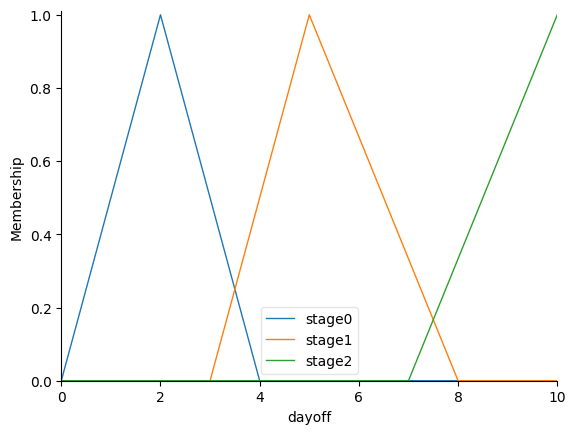

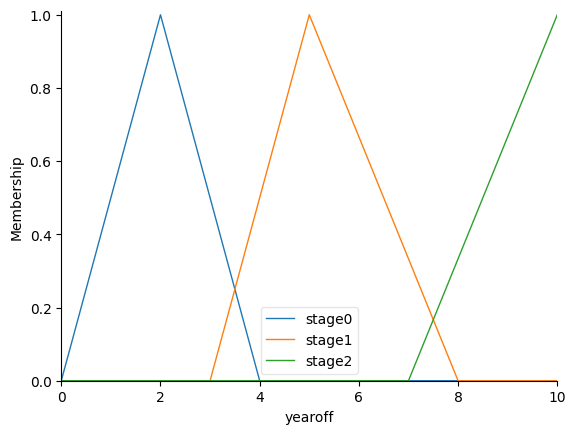

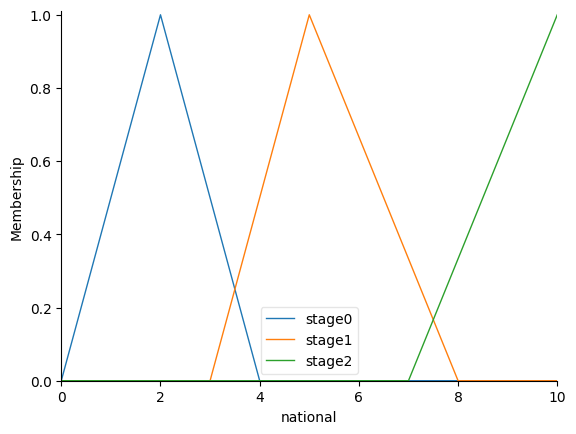

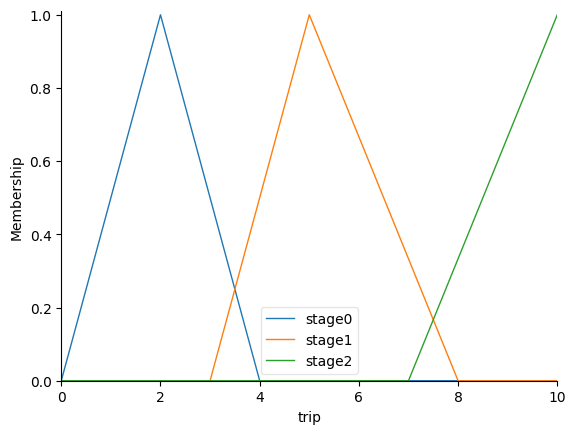

In [48]:
#view antecedent
x1.view_antecedent(dayoff)
x2.view_antecedent(yearoff)
x3.view_antecedent(national)
x4.view_antecedent(trip)


In [49]:

#consequent final value

y = fuzzylogic_trimf_3stage_rule('final_value',0,10,[[0,0,5],[3,5,7],[5,10,10]])
y_range = y.set_input_range(1) 
con_y = y.set_consequent(y_range)


In [50]:
#initialize fuzzy system & set antecedent stage list
anteceLIST = [dayoff,yearoff,national,trip]
model = fuzzylogic_system(con_y,anteceLIST,'centroid')
antecedent_stage = model.set_antecedent_2Dlist(3)
print('antecedent stage list: \n',antecedent_stage)

antecedent stage list: 
 [[dayoff[stage0] dayoff[stage1] dayoff[stage2]]
 [yearoff[stage0] yearoff[stage1] yearoff[stage2]]
 [national[stage0] national[stage1] national[stage2]]
 [trip[stage0] trip[stage1] trip[stage2]]]


In [51]:
#set fuzzy rules
low,medium,high = model.set_rule(antecedent_stage)

In [52]:
#set input value
input_value = {'dayoff':grade_dayoff,'yearoff':grade_yearoff,'national':grade_holiday,'trip':grade_trip} 
SA = model.defuzzy_function(low,medium,high,input_value,'final_value')

defuzzy method: centroid
--------------------------------
finish rule setting
--------------------------------
finish system initialization
--------------------------------
dayoff : 2
yearoff : 10
national : 9
trip : 9
finish value setting
--------------------------------
finish computing
--------------------------------
FINAL GRADE:  1.81


In [16]:
SA.output.get('final_value')

1.8055555501538851

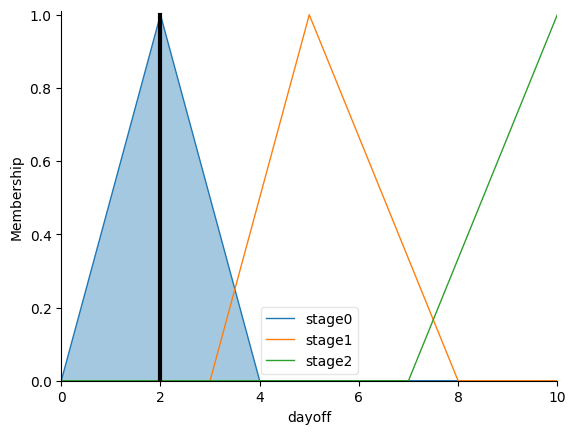

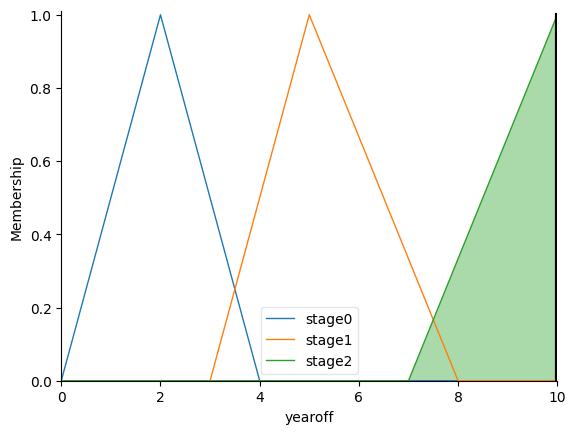

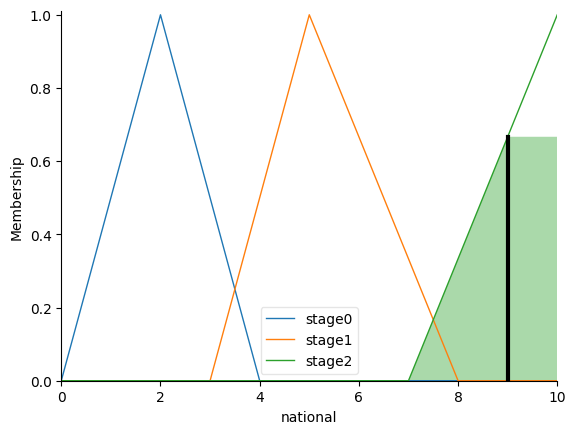

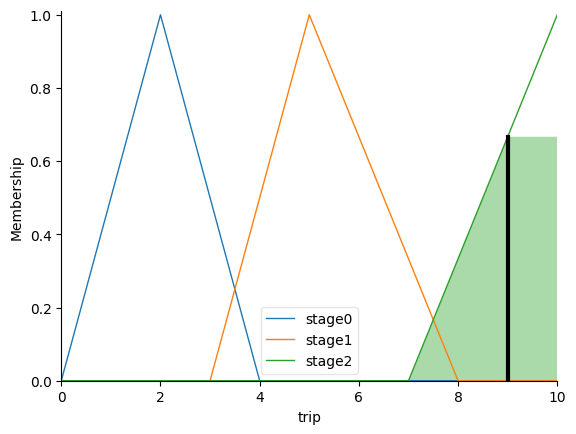

In [17]:
#view output
model.view_output(SA,anteceLIST)

In [18]:
#record the input value and set into checking 
value_recording = model.record_input_value(SA)
value_recording

Antecedent: dayoff
Antecedent: yearoff
Antecedent: national
Antecedent: trip


{'Antecedent: dayoff': 2,
 'Antecedent: yearoff': 10,
 'Antecedent: national': 9,
 'Antecedent: trip': 9}

### overall checking

#### 1.checking - 班表資訊

In [54]:
#initialization
test2 = AllDataTransformer()


#check
update = test2.CheckifShiftisacceptable('overall_2')

#upload
if update:
    test2.UpdateAllshift('overall_2')

#return
df2 = test2.ReturnAllShift()


班表符合規定
已上傳班表


In [55]:
#DictionaryforNumberofShift

NumberofShift = test2.DictionaryforNumberofShift()
NumberofOperationRoom = test2.ArrayforNumberofOperationRoom()
duty6,mark6 = test2.DataFrameforSixDutyOneFree()
PerDayOff = test2.listforPerDayOff()
weekend,markw = test2.DataFrameforweekend()

#### 1.checking - 檢核內容

In [56]:
test_all = overall_checking()

#check
grade_numberofshift,grade_duty6,grade_numberofperday,grade_weekend,overtime\
      = test_all.check_all(NumberofShift,NumberofOperationRoom,duty6,PerDayOff,weekend)
# print(f'一般班別檢測分數: {grade_numberofshift},\n\
# 手術房檢測分數:{grade_numberofoperation},\n\
# 做六休一檢測:{grade_duty6},\n\
# 每日可休人數檢測分數:{grade_numberofperday},\n\
# 一例一休檢測分數:{grade_weekend}')

print(f'一般班別檢測分數: {grade_numberofshift},\n\
做六休一檢測:{grade_duty6},\n\
每日可休人數檢測分數:{grade_numberofperday},\n\
一例一休檢測分數:{grade_weekend}\n')

test_all.print_suggestion()



一般班別檢測分數: 1,
做六休一檢測:9.09090909090909,
每日可休人數檢測分數:5,
一例一休檢測分數:9.09090909090909

------------一般班別需求人數檢核結果------------
小於需求人數的班:
1.1號73差1人

2.3號73差1人

3.4號73差2人

4.5號73差2人

5.6號73差2人

6.7號73差2人

7.8號73差2人

8.10號73差2人

9.11號73差2人

10.12號73差2人

11.13號73差2人

12.14號73差2人

13.15號73差2人

14.17號73差2人

15.18號73差2人

16.19號73差2人

17.20號73差2人

18.21號73差2人

19.22號73差2人

20.24號73差2人

21.25號73差2人

22.26號73差2人

23.27號73差1人

24.28號73差2人

25.29號73差2人

26.1號73'差6人

27.3號73'差6人

28.4號73'差5人

29.5號73'差6人

30.6號73'差4人

31.7號73'差5人

32.8號73'差6人

33.10號73'差5人

34.11號73'差5人

35.12號73'差4人

36.13號73'差5人

37.14號73'差6人

38.15號73'差6人

39.17號73'差5人

40.18號73'差5人

41.19號73'差5人

42.20號73'差5人

43.21號73'差6人

44.22號73'差6人

45.24號73'差4人

46.25號73'差5人

47.26號73'差6人

48.27號73'差6人

49.28號73'差6人

50.29號73'差6人

51.1號84差37人

52.2號84差9人

53.3號84差37人

54.4號84差37人

55.5號84差37人

56.6號84差37人

57.7號84差37人

58.8號84差37人

59.9號84差9人

60.10號84差37人

61.11號84差37人

62.12號84差37人

63.13號84差37人

64.14號84差37人

65.15號84差37人

66.16號84差9人

67.17號84差3

#### 2.fuzzy

In [57]:
#antecedent 1
#一般班別最低需求人數

r_numberofshift = [[0,2,5],[4,5,8],[7,9,10]]
s1 = fuzzylogic_trimf_3stage_rule('numberofshift',0,10,r_numberofshift)
s1_range = s1.set_input_range(1)
numberofshift = s1.set_antecedent(s1_range)

# #antecedent  2
# #手術房最低需求人數
# r_numberofoperation = [[0,2,4],[3,5,8],[7,9,10]]
# s2 = fuzzylogic_trimf_3stage_rule('numberofoperation',0,10,r_numberofoperation)
# s2_range = s2.set_input_range(1)
# numberofoperation = s2.set_antecedent(s2_range)

#antecedent 3
#每日可休人數
r_perdayoff = [[0,2,4],[3,5,8],[7,9,10]]
s3 = fuzzylogic_trimf_3stage_rule('numberofperdayoff',0,10,r_perdayoff)
s3_range = s3.set_input_range(1)
numberofperdayoff = s3.set_antecedent(s3_range)

#antecedent 4
#做六休一檢測
r_duty6 = [[0,2,4],[3,5,8],[7,9,10]]
s4 = fuzzylogic_trimf_3stage_rule('duty6_off1',0,10,r_duty6)
s4_range = s4.set_input_range(1)
numberofduty6 = s4.set_antecedent(s4_range)

#antecedent 5
#一例一休檢測
r_weekend = [[0,2,4],[3,5,8],[7,9,10]]
s5 = fuzzylogic_trimf_3stage_rule('weekend',0,10,r_weekend)
s5_range = s5.set_input_range(0.5)
numberofweekend = s5.set_antecedent(s5_range)



c:\Users\laimm\anaconda3\envs\jubo\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


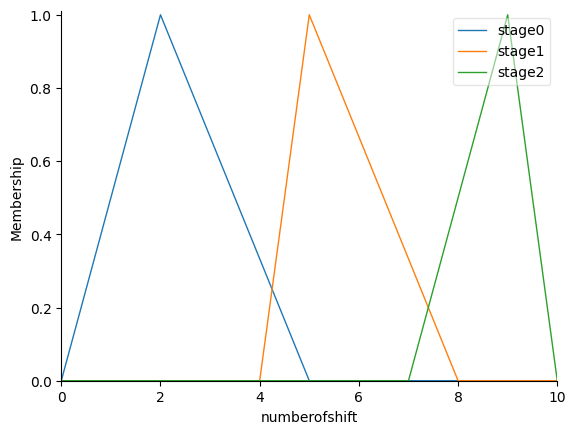

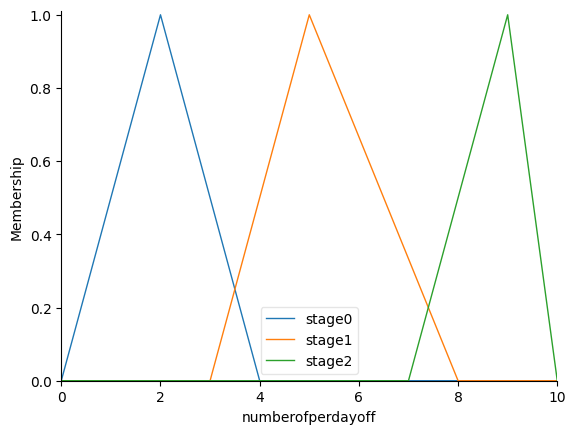

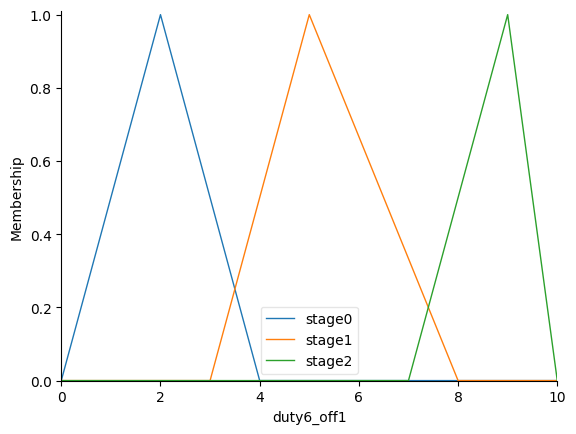

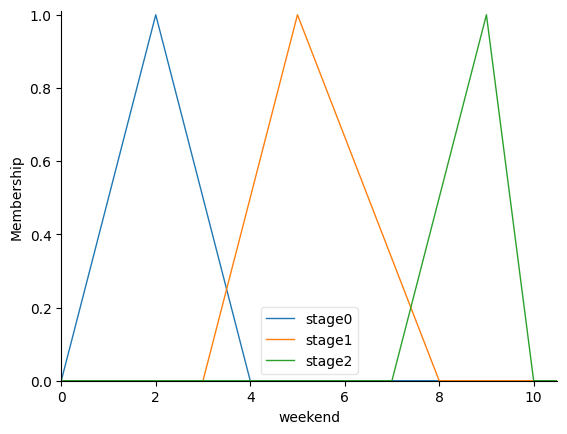

In [58]:
#view antecedent
s1.view_antecedent(numberofshift)
s3.view_antecedent(numberofperdayoff)
s4.view_antecedent(numberofduty6)
s5.view_antecedent(numberofweekend)

In [60]:
#consequent final value

y2 = fuzzylogic_trimf_3stage_rule('final_value_all',0,10,[[0,0,5],[3,5,7],[5,9,10]])
y2_range = y2.set_input_range(0.5) 
con_y2 = y2.set_consequent(y2_range)

In [61]:
#initialize fuzzy system & set antecedent stage list
# s1.view_antecedent(numberofshift)
# s2.view_antecedent(numberofoperation)
# s3.view_antecedent(numberofperdayoff)
# s4.view_antecedent(numberofduty6)
# s5.view_antecedent(numberofweekend)



anteceLIST2 = [numberofshift,numberofperdayoff,numberofduty6,numberofweekend]
model2 = fuzzylogic_system(con_y2,anteceLIST2)
antecedent_stage2 = model2.set_antecedent_2Dlist(3)
print('antecedent stage list: \n',antecedent_stage2)

antecedent stage list: 
 [[numberofshift[stage0] numberofshift[stage1] numberofshift[stage2]]
 [numberofperdayoff[stage0] numberofperdayoff[stage1]
  numberofperdayoff[stage2]]
 [duty6_off1[stage0] duty6_off1[stage1] duty6_off1[stage2]]
 [weekend[stage0] weekend[stage1] weekend[stage2]]]


In [62]:
#set fuzzy rules
low,medium,high = model2.set_rule(antecedent_stage2)

In [63]:
#set input value
input_value = {'numberofshift':grade_numberofshift,'numberofperdayoff':grade_duty6,'duty6_off1':grade_numberofperday,'weekend':grade_weekend} 
SA = model2.defuzzy_function(low,medium,high,input_value,'final_value_all')

defuzzy method: centroid
--------------------------------
finish rule setting
--------------------------------
finish system initialization
--------------------------------
numberofshift : 1
numberofperdayoff : 9.09090909090909
duty6_off1 : 5
weekend : 9.09090909090909
finish value setting
--------------------------------
finish computing
--------------------------------
FINAL GRADE:  1.94
